In [ ]:
#importacion de librerias necesarias

import os, datetime
import numpy as np
import pandas as pd
import tensorflow as tf   # <-- aquí está la clave
from tensorflow.keras import layers as L, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
#lECTURA DE NUESTROS DATOS Y FIJAMOS VARIABLES
ruta_train = r"C:\Users\anaco\Downloads\data\archive\train"
ruta_test = r"C:\Users\anaco\Downloads\data\archive\test"
height_shape = 48
width_shape = 48 #definimos una variable para fijar el tamaño (alto y ancho) al que se redimensionarán todas las imágenes antes de pasarlas por la red neurona
batch_size = 32 # sacado de la literatura es el número de imágenes que el modelo procesará a la vez antes de actualizar los pesos - un EPOCH o paso de entrenamiento
epochs = 60 #cuántas veces el modelo verá todo el dataset completo de entrenamiento - lo usaremos en el .fit
num_classes = 7
class_names = ['angry','disgust','fear','happy','neutral','sad','surprise']

In [ ]:
SEED = 42
tf.random.set_seed(SEED)
VAL_SPLIT = 0.20    # 20% de validación a partir de ruta_train

# ========= Generadores de datos con split interno (train/val) =========
# Augment en train, normalización en ambos. Mismo datagen para usar 'subset'.
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=8,
    width_shift_range=0.06,
    height_shift_range=0.06,
    zoom_range=0.10,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=VAL_SPLIT
)

# TRAIN (80% por defecto)
train_generator = datagen.flow_from_directory(
    ruta_train,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True,
    seed=SEED,
    subset="training"
)

# VALIDATION (20% por defecto)
val_generator = datagen.flow_from_directory(
    ruta_train,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False,               # importante para métricas estables
    seed=SEED,
    subset="validation"
)

# TEST (solo normalización, sin augment ni mezcla)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    ruta_test,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',    # si solo quieres predict sin etiquetas, usa class_mode=None
    shuffle=False
)

num_classes  = train_generator.num_classes
class_names  = list(train_generator.class_indices.keys())

# ========= Class Weights (por posible desbalance) =========
y_train_int = train_generator.classes  # etiquetas enteras del subset "training"
cls = np.arange(num_classes)
cw = compute_class_weight(class_weight='balanced', classes=cls, y=y_train_int)
class_weight = {i: float(w) for i, w in enumerate(cw)}
print("Class weights:", class_weight)

# ========= Modelo CNN (from scratch optimizada) =========
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Input, Conv2D, SeparableConv2D, BatchNormalization,
                                     ReLU, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense)

num_clases = len(class_names)
model = Sequential([
    Input(shape=(48, 48, 1), name="input_2"),

    # Bloque 1: 32, 32 -> pool -> drop
    Conv2D(32, (3,3), padding='same', use_bias=False, name="conv2d_7"),
    BatchNormalization(name="batch_normalization_8"),
    ReLU(name="re_lu_7"),

    Conv2D(32, (3,3), padding='same', use_bias=False, name="conv2d_8"),
    BatchNormalization(name="batch_normalization_9"),
    ReLU(name="re_lu_8"),

    MaxPooling2D(pool_size=(2,2), name="max_pooling2d_3"),
    Dropout(0.25, name="dropout_4"),

    # Bloque 2: 64, 64 -> pool -> drop
    Conv2D(64, (3,3), padding='same', use_bias=False, name="conv2d_9"),
    BatchNormalization(name="batch_normalization_10"),
    ReLU(name="re_lu_9"),

    Conv2D(64, (3,3), padding='same', use_bias=False, name="conv2d_10"),
    BatchNormalization(name="batch_normalization_11"),
    ReLU(name="re_lu_10"),

    MaxPooling2D(pool_size=(2,2), name="max_pooling2d_4"),
    Dropout(0.25, name="dropout_5"),

    # Bloque 3: 128, 128 -> pool -> drop
    Conv2D(128, (3,3), padding='same', use_bias=False, name="conv2d_11"),
    BatchNormalization(name="batch_normalization_12"),
    ReLU(name="re_lu_11"),

    Conv2D(128, (3,3), padding='same', use_bias=False, name="conv2d_12"),
    BatchNormalization(name="batch_normalization_13"),
    ReLU(name="re_lu_12"),

    MaxPooling2D(pool_size=(2,2), name="max_pooling2d_5"),
    Dropout(0.25, name="dropout_6"),

    # Separable conv + GAP + drop
    SeparableConv2D(128, (3,3), padding='same', use_bias=False, name="separable_conv2d_1"),
    BatchNormalization(name="batch_normalization_14"),
    ReLU(name="re_lu_13"),

    GlobalAveragePooling2D(name="global_average_pooling2d_1"),
    Dropout(0.5, name="dropout_7"),

    # Cabeza
    Dense(num_classes, activation='softmax', name="dense_1")
])

model.summary()

# ========= Compilación =========
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss=loss,
              metrics=["accuracy"])

# ========= Callbacks (incluye TensorBoard) =========
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
cbs = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ModelCheckpoint("best.keras", monitor="val_loss", save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
    TensorBoard(log_dir=logdir, histogram_freq=1)
]

# ========= Entrenamiento =========
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    class_weight=class_weight,
    callbacks=cbs,
    verbose=1
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Class weights: {0: 1.0266404434114071, 1: 9.401555464592715, 2: 1.0009587727708533, 3: 0.5684585684585685, 4: 0.826068191627104, 5: 0.8491570541259982, 6: 1.2933160650937552}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 48, 48, 32)        288       
                                                                 
 batch_normalization_8 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 re_lu_7 (ReLU)              (None, 48, 48, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 48, 48, 32)        9216      
                  


VALIDACIÓN
180/180 [==============================] - 32s 178ms/step

Macro-F1 (VALID): 0.5841

Classification report (VALIDACION):

              precision    recall  f1-score   support

       angry     0.5427    0.5569    0.5497       799
     disgust     0.3815    0.7586    0.5077        87
        fear     0.5477    0.2662    0.3583       819
       happy     0.8549    0.8247    0.8395      1443
     neutral     0.5362    0.7080    0.6102       993
         sad     0.5000    0.4710    0.4851       966
    surprise     0.6866    0.7981    0.7381       634

    accuracy                         0.6241      5741
   macro avg     0.5785    0.6262    0.5841      5741
weighted avg     0.6270    0.6241    0.6150      5741


Matriz de confusión VALIDACION (%)  [filas = clase real]:

          angry  disgust  fear  happy  neutral   sad  surprise
angry      55.7      4.8   5.0    4.6     15.1  11.6       3.1
disgust    14.9     75.9   2.3    0.0      3.4   3.4       0.0
fear       15.6     

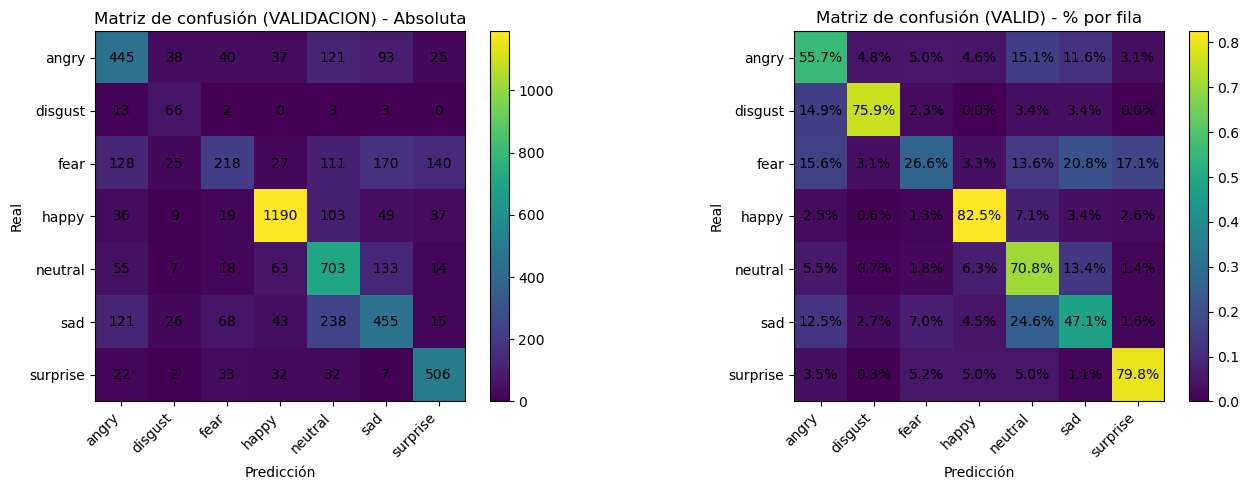


TEST
225/225 [==============================] - 30s 134ms/step - loss: 1.1192 - accuracy: 0.6311

Test metrics: {'loss': 1.119160532951355, 'accuracy': 0.6310949921607971}
225/225 [==============================] - 30s 133ms/step

Macro-F1 (TEST): 0.5873

Classification report (TEST):

              precision    recall  f1-score   support

       angry     0.5326    0.5971    0.5630       958
     disgust     0.3776    0.6667    0.4821       111
        fear     0.5672    0.2598    0.3563      1024
       happy     0.8746    0.8219    0.8474      1774
     neutral     0.5081    0.7616    0.6095      1233
         sad     0.5530    0.4395    0.4897      1247
    surprise     0.7213    0.8099    0.7630       831

    accuracy                         0.6311      7178
   macro avg     0.5906    0.6223    0.5873      7178
weighted avg     0.6408    0.6311    0.6210      7178


Matriz de confusión TEST (%)  [filas = clase real]:

          angry  disgust  fear  happy  neutral   sad  surpris

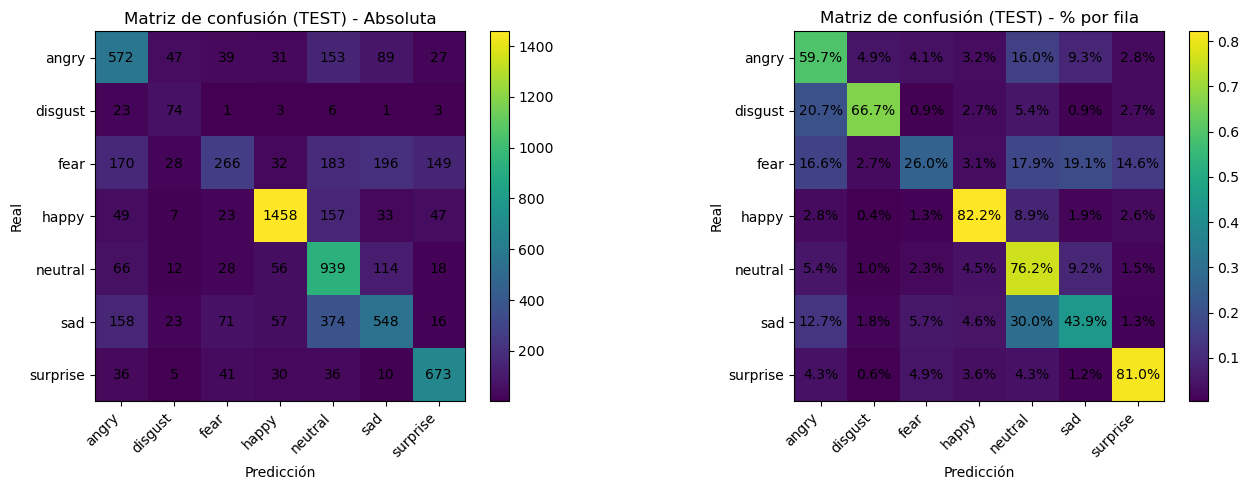


Ejemplo de predicciones en TEST (primeras 10):
angry\PrivateTest_10131363.jpg -> angry
angry\PrivateTest_10304478.jpg -> angry
angry\PrivateTest_1054527.jpg -> sad
angry\PrivateTest_10590091.jpg -> angry
angry\PrivateTest_1109992.jpg -> angry
angry\PrivateTest_11296953.jpg -> fear
angry\PrivateTest_12000629.jpg -> neutral
angry\PrivateTest_12008383.jpg -> angry
angry\PrivateTest_12191716.jpg -> sad
angry\PrivateTest_1221822.jpg -> angry


In [ ]:

# Evaluación  VAL & TEST
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score
num_classes = len(class_names)


# VALIDACIÓN
print("\n" + "="*70)
print("VALIDACIÓN")
print("="*70)

val_generator.reset()
y_prob_val = model.predict(val_generator, verbose=1)
y_pred_val = np.argmax(y_prob_val, axis=1)
y_true_val = val_generator.classes

macro_f1_val = f1_score(y_true_val, y_pred_val, average='macro')
print(f"\nMacro-F1 (VALID): {macro_f1_val:.4f}\n")

print("Classification report (VALIDACION):\n")
print(classification_report(y_true_val, y_pred_val, target_names=class_names, digits=4))

cm_val = confusion_matrix(y_true_val, y_pred_val, labels=np.arange(num_classes))
cm_val_pct = cm_val.astype(np.float64) / cm_val.sum(axis=1, keepdims=True)
cm_val_pct = np.nan_to_num(cm_val_pct)

cm_val_df = pd.DataFrame(cm_val_pct * 100.0, index=class_names, columns=class_names).round(1)
print("\nMatriz de confusión VALIDACION (%)  [filas = clase real]:\n")
print(cm_val_df.to_string())

# --- Plots VALIDACION ---
plt.figure(figsize=(14,5))

# Absoluta
ax = plt.subplot(1,2,1)
im = ax.imshow(cm_val, interpolation='nearest')
ax.set_title("Matriz de confusión (VALIDACION) - Absoluta")
ax.set_xlabel("Predicción")
ax.set_ylabel("Real")
ax.set_xticks(range(num_classes)); ax.set_yticks(range(num_classes))
ax.set_xticklabels(class_names, rotation=45, ha='right'); ax.set_yticklabels(class_names)
for i in range(num_classes):
    for j in range(num_classes):
        ax.text(j, i, cm_val[i, j], ha="center", va="center")
plt.colorbar(im, fraction=0.046, pad=0.04)

# Porcentaje por fila
ax = plt.subplot(1,2,2)
im = ax.imshow(cm_val_pct, interpolation='nearest')
ax.set_title("Matriz de confusión (VALID) - % por fila")
ax.set_xlabel("Predicción")
ax.set_ylabel("Real")
ax.set_xticks(range(num_classes)); ax.set_yticks(range(num_classes))
ax.set_xticklabels(class_names, rotation=45, ha='right'); ax.set_yticklabels(class_names)
for i in range(num_classes):
    for j in range(num_classes):
        ax.text(j, i, f"{cm_val_pct[i, j]*100:0.1f}%", ha="center", va="center")
plt.colorbar(im, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


# TEST

print("\n" + "="*70)
print("TEST")
print("="*70)

# Métricas de Keras
if test_generator.class_mode is not None:
    test_generator.reset()
    test_metrics = model.evaluate(test_generator, verbose=1)
    print("\nTest metrics:", dict(zip(model.metrics_names, test_metrics)))

# Predicciones y report
test_generator.reset()
y_prob_test = model.predict(test_generator, verbose=1)
y_pred_test = np.argmax(y_prob_test, axis=1)
y_true_test = test_generator.classes

macro_f1_test = f1_score(y_true_test, y_pred_test, average='macro')
print(f"\nMacro-F1 (TEST): {macro_f1_test:.4f}\n")

print("Classification report (TEST):\n")
print(classification_report(y_true_test, y_pred_test, target_names=class_names, digits=4))

cm_test = confusion_matrix(y_true_test, y_pred_test, labels=np.arange(num_classes))
cm_test_pct = cm_test.astype(np.float64) / cm_test.sum(axis=1, keepdims=True)
cm_test_pct = np.nan_to_num(cm_test_pct)

cm_test_df = pd.DataFrame(cm_test_pct * 100.0, index=class_names, columns=class_names).round(1)
print("\nMatriz de confusión TEST (%)  [filas = clase real]:\n")
print(cm_test_df.to_string())

# --- Plots TEST ---
plt.figure(figsize=(14,5))

# Absoluta
ax = plt.subplot(1,2,1)
im = ax.imshow(cm_test, interpolation='nearest')
ax.set_title("Matriz de confusión (TEST) - Absoluta")
ax.set_xlabel("Predicción")
ax.set_ylabel("Real")
ax.set_xticks(range(num_classes)); ax.set_yticks(range(num_classes))
ax.set_xticklabels(class_names, rotation=45, ha='right'); ax.set_yticklabels(class_names)
for i in range(num_classes):
    for j in range(num_classes):
        ax.text(j, i, cm_test[i, j], ha="center", va="center")
plt.colorbar(im, fraction=0.046, pad=0.04)

# Porcentaje por fila
ax = plt.subplot(1,2,2)
im = ax.imshow(cm_test_pct, interpolation='nearest')
ax.set_title("Matriz de confusión (TEST) - % por fila")
ax.set_xlabel("Predicción")
ax.set_ylabel("Real")
ax.set_xticks(range(num_classes)); ax.set_yticks(range(num_classes))
ax.set_xticklabels(class_names, rotation=45, ha='right'); ax.set_yticklabels(class_names)
for i in range(num_classes):
    for j in range(num_classes):
        ax.text(j, i, f"{cm_test_pct[i, j]*100:0.1f}%", ha="center", va="center")
plt.colorbar(im, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# Ver primeras 10 predicciones de TEST legibles

test_filenames = getattr(test_generator, "filenames", None)
if test_filenames is not None:
    print("\nEjemplo de predicciones en TEST (primeras 10):")
    for f, c in list(zip(test_filenames, y_pred_test))[:10]:
        print(f"{f} -> {class_names[c]}")

In [ ]:
c

Capa de embeddings usada (-3): global_average_pooling2d_1
Found 22968 images belonging to 7 classes.
225/225 [==============================] - 30s 133ms/step
Embeddings shapes (train/val/test): (22968, 128) (5741, 128) (7178, 128)


In [ ]:
# 10A) Clasificador sobre TODAS las clases (LR multinomial) ---

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
clf_all = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        max_iter=5000,
        multi_class='multinomial',
        class_weight='balanced',
        n_jobs=-1,
        C=1.0,
        solver='lbfgs'
    ))
])

clf_all.fit(Z_train, y_train_int2)
y_val_pred_all  = clf_all.predict(Z_val)
y_test_pred_all = clf_all.predict(Z_test)

print("\n===== ESPECIALIZADO (TODAS LAS CLASES) → VALIDACIÓN =====")
print(classification_report(y_val_int, y_val_pred_all, target_names=le.classes_, digits=4))
print("Macro-F1 VAL:", f1_score(y_val_int, y_val_pred_all, average='macro'))

print("\n===== ESPECIALIZADO (TODAS LAS CLASES) → TEST =====")
print(classification_report(y_test_int, y_test_pred_all, target_names=le.classes_, digits=4))
print("Macro-F1 TEST:", f1_score(y_test_int, y_test_pred_all, average='macro'))


===== ESPECIALIZADO (TODAS LAS CLASES) → VALIDACIÓN =====
              precision    recall  f1-score   support

       angry     0.5537    0.5419    0.5478       799
     disgust     0.6395    0.6322    0.6358        87
        fear     0.4496    0.3761    0.4096       819
       happy     0.8450    0.8274    0.8361      1443
     neutral     0.6173    0.5670    0.5911       993
         sad     0.4738    0.5518    0.5098       966
    surprise     0.6883    0.8013    0.7405       634

    accuracy                         0.6260      5741
   macro avg     0.6096    0.6139    0.6101      5741
weighted avg     0.6258    0.6260    0.6243      5741

Macro-F1 VAL: 0.6101009251794551

===== ESPECIALIZADO (TODAS LAS CLASES) → TEST =====
              precision    recall  f1-score   support

       angry     0.5404    0.5929    0.5655       958
     disgust     0.6408    0.5946    0.6168       111
        fear     0.4905    0.3779    0.4269      1024
       happy     0.8810    0.8343    0.85

In [ ]:
# 10B) Subset fino (angry/fear/sad) ---
subset_names = ['angry', 'fear', 'sad']
mask_tr = np.isin(y_train_str, subset_names)
mask_va = np.isin(y_val_str,   subset_names)
mask_te = np.isin(y_test_str,  subset_names)

Z_tr_sub = Z_train[mask_tr]
Z_va_sub = Z_val[mask_va]
Z_te_sub = Z_test[mask_te]

le_sub = LabelEncoder().fit(y_train_str[mask_tr])
y_tr_sub = le_sub.transform(y_train_str[mask_tr])
y_va_sub = le_sub.transform(y_val_str[mask_va])
y_te_sub = le_sub.transform(y_test_str[mask_te])

clf_sub = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        max_iter=5000,
        multi_class='multinomial',
        class_weight='balanced',
        n_jobs=-1,
        C=1.0,
        solver='lbfgs'
    ))
])
clf_sub.fit(Z_tr_sub, y_tr_sub)

y_val_pred_sub  = clf_sub.predict(Z_va_sub)
y_test_pred_sub = clf_sub.predict(Z_te_sub)

print("\n===== ESPECIALIZADO (SUBCONJUNTO: angry/fear/sad) → VALIDACIÓN =====")
print(classification_report(y_va_sub, y_val_pred_sub, target_names=le_sub.classes_, digits=4))
print("Macro-F1 VAL (subset):", f1_score(y_va_sub, y_val_pred_sub, average='macro'))

print("\n===== ESPECIALIZADO (SUBCONJUNTO: angry/fear/sad) → TEST =====")
print(classification_report(y_te_sub, y_test_pred_sub, target_names=le_sub.classes_, digits=4))
print("Macro-F1 TEST (subset):", f1_score(y_te_sub, y_test_pred_sub, average='macro'))


===== ESPECIALIZADO (SUBCONJUNTO: angry/fear/sad) → VALIDACIÓN =====
              precision    recall  f1-score   support

       angry     0.6501    0.6233    0.6364       799
        fear     0.6047    0.5604    0.5817       819
         sad     0.6261    0.6863    0.6548       966

    accuracy                         0.6269      2584
   macro avg     0.6270    0.6234    0.6243      2584
weighted avg     0.6267    0.6269    0.6260      2584

Macro-F1 VAL (subset): 0.6243285298280297

===== ESPECIALIZADO (SUBCONJUNTO: angry/fear/sad) → TEST =====
              precision    recall  f1-score   support

       angry     0.6294    0.6701    0.6491       958
        fear     0.6239    0.5459    0.5823      1024
         sad     0.6436    0.6776    0.6602      1247

    accuracy                         0.6336      3229
   macro avg     0.6323    0.6312    0.6305      3229
weighted avg     0.6331    0.6336    0.6322      3229

Macro-F1 TEST (subset): 0.6305294875575779


In [ ]:
# 11) Router + ensamble

labels = list(le.classes_)
C = len(labels)

def predict_general_probs(model, gen):
    gen.reset()
    return model.predict(gen, verbose=1)

p_val_gen  = predict_general_probs(model, val_generator)
p_test_gen = predict_general_probs(model, test_generator)

# Probabilidades del especializado "todas las clases" alineadas al orden global
p_val_all  = clf_all.predict_proba(Z_val)
p_test_all = clf_all.predict_proba(Z_test)

def ensemble_probs(p_gen, p_all, alpha=0.5):
    return alpha * p_gen + (1.0 - alpha) * p_all

def print_eval(title, y_true, p, class_names):
    y_pred = p.argmax(axis=1)
    print(f"\n===== {title} =====")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    print("Macro-F1:", f1_score(y_true, y_pred, average='macro'))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    print("Confusión normalizada (%):\n", (cm*100).round(1))

print_eval("BASELINE — General SOLO (VAL)",  y_val_int,  p_val_gen,  class_names)
print_eval("BASELINE — General SOLO (TEST)", y_test_int, p_test_gen, class_names)

print_eval("Especializado TODAS LAS CLASES (VAL)",  y_val_int,  p_val_all,  class_names)
print_eval("Especializado TODAS LAS CLASES (TEST)", y_test_int, p_test_all, class_names)

225/225 [==============================] - 30s 132ms/step

===== BASELINE — General SOLO (VAL) =====
              precision    recall  f1-score   support

       angry     0.5385    0.5519    0.5451       799
     disgust     0.3584    0.7126    0.4769        87
        fear     0.5469    0.2491    0.3423       819
       happy     0.8464    0.8170    0.8315      1443
     neutral     0.5296    0.7110    0.6071       993
         sad     0.5000    0.4720    0.4856       966
    surprise     0.6843    0.7965    0.7362       634

    accuracy                         0.6189      5741
   macro avg     0.5720    0.6158    0.5749      5741
weighted avg     0.6224    0.6189    0.6089      5741

Macro-F1: 0.5749429247081128
Confusión normalizada (%):
 [[55.2  5.1  4.9  4.9 14.6 12.   3.3]
 [18.4 71.3  1.1  2.3  2.3  3.4  1.1]
 [16.1  2.2 24.9  4.  13.9 21.6 17.2]
 [ 2.6  0.8  1.7 81.7  7.8  3.1  2.4]
 [ 5.9  0.8  1.8  6.2 71.1 13.   1.1]
 [11.5  3.   6.2  4.7 25.5 47.2  2. ]
 [ 3.6  0.6  4.3 

In [ ]:
# 11) Router General + Fino subset angry/fear/sad) + Ensamble

# Umbrales del router
TAU_GENERAL = 0.55   # confianza mínima del modelo general para considerar el fino
TAU_FINO    = 0.65   # confianza mínima del fino para sustituir
MARGIN      = 0.00   # separación mínima entre 1ª y 2ª clase del fino

labels = list(le.classes_)
C = len(labels)

def predict_general_probs(model, gen):
    gen.reset()
    return model.predict(gen, verbose=1)

# 1) Probabilidades del modelo general (softmax Keras)
p_val_gen  = predict_general_probs(model, val_generator)
p_test_gen = predict_general_probs(model, test_generator)

# 2) Probabilidades del especializado "todas las clases" (alineadas)
# (clf_all fue entrenado con enteros [0..C-1] por y_train_int2; su .classes_ debe tener ese mismo orden)
p_val_all  = clf_all.predict_proba(Z_val)
p_test_all = clf_all.predict_proba(Z_test)

# 3) Router: reemplaza por el fino (subset angry/fear/sad) cuando el general está seguro y el fino también
subset_names = ['angry', 'fear', 'sad']  # mismo subset que para clf_sub

def router_predict(p_gen, Z, clf_sub, le_global, le_sub, subset_names,
                   tau_general=0.55, tau_fino=0.65, margin=0.00):
    p_final = p_gen.copy()

    # Condición 1: el top del general pertenece al subset Y tiene alta confianza
    top_gen = p_gen.argmax(axis=1)
    p_top_gen = p_gen.max(axis=1)
    belongs_subset = np.isin(le_global.classes_[top_gen], subset_names)
    use_router_mask = (belongs_subset) & (p_top_gen >= tau_general)

    # Scores del fino (clf_sub) sobre Z (embeddings -3)
    p_sub = clf_sub.predict_proba(Z)
    order_sub = np.argsort(-p_sub, axis=1)
    top_sub_idx = order_sub[:, 0]
    second_sub_idx = order_sub[:, 1] if p_sub.shape[1] > 1 else np.full(len(Z), -1)

    p_top_sub = p_sub[np.arange(len(Z)), top_sub_idx]
    p_second_sub = np.where(second_sub_idx >= 0, p_sub[np.arange(len(Z)), second_sub_idx], 0.0)

    # Condición 2: el fino también está seguro y con margen
    cond_fino = (p_top_sub >= tau_fino) & ((p_top_sub - p_second_sub) >= margin)

    apply_mask = use_router_mask & cond_fino

    # Mapear probs del fino (orden le_sub.classes_) al espacio global (orden le_global.classes_)
    name_to_pos = {name: np.where(le_global.classes_ == name)[0][0] for name in le_global.classes_}

    idx_apply = np.where(apply_mask)[0]
    for i in idx_apply:
        out = np.zeros(C, dtype=np.float32)
        for j, cls_name in enumerate(le_sub.classes_):
            gpos = name_to_pos[cls_name]
            out[gpos] = p_sub[i, j]
        s = out.sum()
        p_final[i] = out if s == 0 else out / s

    return p_final, apply_mask

# Aplicar router en VAL y TEST
p_val_router,  routed_val  = router_predict(
    p_val_gen, Z_val, clf_sub, le, le_sub, subset_names,
    tau_general=TAU_GENERAL, tau_fino=TAU_FINO, margin=MARGIN
)
p_test_router, routed_test = router_predict(
    p_test_gen, Z_test, clf_sub, le, le_sub, subset_names,
    tau_general=TAU_GENERAL, tau_fino=TAU_FINO, margin=MARGIN
)

# 4) Ensamble general + especializado todas las clases
def ensemble_probs(p_gen, p_all, alpha=0.5):
    return alpha * p_gen + (1.0 - alpha) * p_all

#  evaluación rápida
def print_eval(title, y_true, p, class_names):
    y_pred = p.argmax(axis=1)
    print(f"\n===== {title} =====")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    print("Macro-F1:", f1_score(y_true, y_pred, average='macro'))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    print("Confusión normalizada (%):\n", (cm*100).round(1))

# 5) Comparativas
print_eval("BASELINE — General SOLO (VAL)",  y_val_int,  p_val_gen,  class_names)
print_eval("BASELINE — General SOLO (TEST)", y_test_int, p_test_gen, class_names)

print_eval("Especializado TODAS LAS CLASES (VAL)",  y_val_int,  p_val_all,  class_names)
print_eval("Especializado TODAS LAS CLASES (TEST)", y_test_int, p_test_all, class_names)

print_eval("ROUTER (General + Fino subset) (VAL)",  y_val_int,  p_val_router,  class_names)
print_eval("ROUTER (General + Fino subset) (TEST)", y_test_int, p_test_router, class_names)

print(f"\nCobertura router VAL:  {routed_val.mean()*100:.1f}%")
print(f"Cobertura router TEST: {routed_test.mean()*100:.1f}%")

#  ensambles con alpha
for alpha in (0.25, 0.5, 0.75):
    print_eval(f"ENSAMBLE α={alpha} (VAL)",  y_val_int,  ensemble_probs(p_val_gen,  p_val_all, alpha), class_names)
    print_eval(f"ENSAMBLE α={alpha} (TEST)", y_test_int, ensemble_probs(p_test_gen, p_test_all, alpha), class_names)

225/225 [==============================] - 31s 138ms/step

===== BASELINE — General SOLO (VAL) =====
              precision    recall  f1-score   support

       angry     0.5437    0.5294    0.5365       799
     disgust     0.3591    0.7471    0.4851        87
        fear     0.5291    0.2772    0.3638       819
       happy     0.8601    0.8267    0.8431      1443
     neutral     0.5346    0.7231    0.6147       993
         sad     0.5084    0.4720    0.4895       966
    surprise     0.6956    0.7965    0.7426       634

    accuracy                         0.6248      5741
   macro avg     0.5758    0.6246    0.5822      5741
weighted avg     0.6276    0.6248    0.6165      5741

Macro-F1: 0.5821905646134932
Confusión normalizada (%):
 [[52.9  6.1  5.8  5.4 14.3 12.   3.5]
 [12.6 74.7  3.4  2.3  2.3  3.4  1.1]
 [16.   2.2 27.7  3.4 14.  20.8 15.9]
 [ 2.2  0.6  1.2 82.7  7.8  2.9  2.7]
 [ 5.4  0.5  2.9  5.4 72.3 12.4  1. ]
 [11.   3.3  8.   3.9 25.3 47.2  1.3]
 [ 3.3  0.6  4.7 